In [78]:
import NDEToolkit as ndt
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# Data import

We import the data and flip its axes for an easier processing.

In [79]:
#Opening file
filename = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Fabricacion Nacho\medidas\Preliminar\Laminado_Preliminar_2\Sin cortar\Segunda_Placa_Nacho_20mms_30mm_11dB_121Z_ascan216x180x505_amplitude.tif')

data = tifffile.imread(filename)
data = np.swapaxes(data, 0, 1)
data = np.swapaxes(data, 1, 2)
print('Shape:',data.shape)

Shape: (180, 216, 504)


# Mean signal

We are going to calculate the mean signal to have a general idea of the signals of this UT measurement. 

We dont want the points of the measurement that does not include material to noise pollute, so we will first select the signals that belong to material points and then compute the mean signal of them.

How can we detect if a signal goes through material or not?

If a signal goes through material, it will have a significant frontwall peak, so we just have to locate them and filter the signals using that peaks.

1. Get the max peak of each signal

2. Select a threshold to determine if a signal has material or not.

3. Filter by the threshold

4. Calculate the mean signal

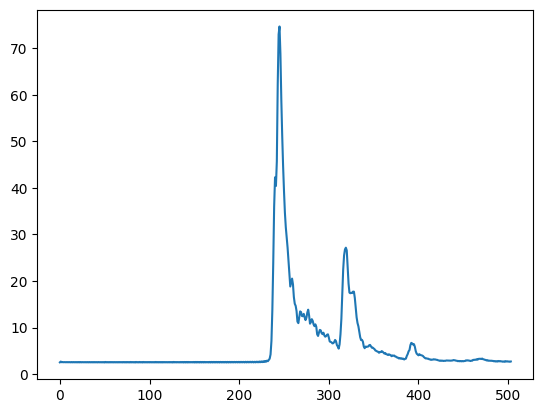

In [80]:
#get the maxs of each signal
maxs = np.max(data, axis=2)

#select the ones that have material
frontwall_threshold = 40
material_indexes = np.where(maxs > frontwall_threshold)

#calcualte the mean signal of the material
mean_signal = np.mean(data[material_indexes], axis=0)

#plot the mean signal
plt.plot(mean_signal)

Now we can use this mean signal as a placeholder for our pre calculations

## Frontwall gate

We are going to select the frontwall gate. This gate will tell our code where to look for the frontwall.

A gate has 3 values:

1. Initial point in time axis

2. Final point in time axis

3. Threshold for the amplitude axis.

With this three values, a gate tells you where to look for the frontwall peak, and the minimum amplitude value a peak has to have to be considered a frontwall peak.

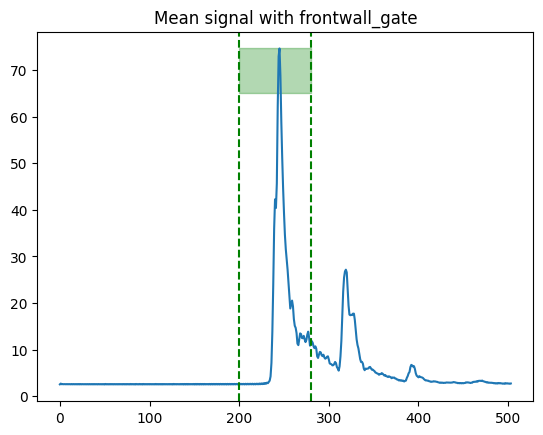

In [81]:
frontwall_gate = [200,280,65]

#plot then mean signal and a two green vertical lines in the frontwall_gate position and fill the area between them from the threshold to the top of the plot. The threshold is in the y axis of the plot.
plt.plot(mean_signal)
plt.axvline(x=frontwall_gate[0], color='green', linestyle='--')
plt.axvline(x=frontwall_gate[1], color='green', linestyle='--')
plt.fill_betweenx([frontwall_gate[2], np.max(mean_signal[frontwall_gate[0]:frontwall_gate[1]])], frontwall_gate[0], frontwall_gate[1], color='green', alpha=0.3)
plt.title('Mean signal with frontwall_gate')
plt.show()

# Backwall gate

We are going to select the backwall gate. This gate will tell our code where to look for the backwall.

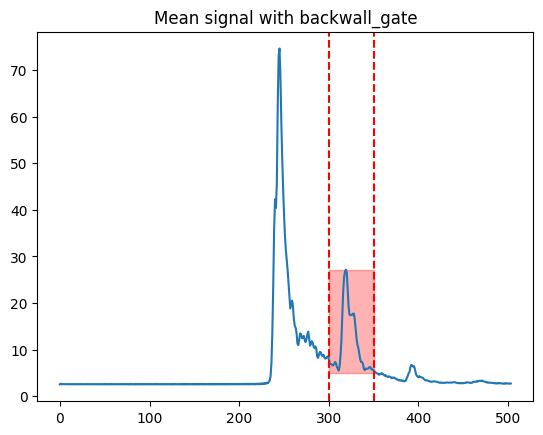

In [82]:
backwall_gate = [300,350,5]

#plot then mean signal and a two red vertical lines in the backwall_gate position and fill the area between them from the threshold to the top of the plot. The threshold is in the y axis of the plot.
plt.plot(mean_signal)
plt.axvline(x=backwall_gate[0], color='red', linestyle='--')
plt.axvline(x=backwall_gate[1], color='red', linestyle='--')
plt.fill_betweenx([backwall_gate[2], np.max(mean_signal[backwall_gate[0]:backwall_gate[1]])], backwall_gate[0], backwall_gate[1], color='red', alpha=0.3)
plt.title('Mean signal with backwall_gate')
plt.show()

# Attenuation Function

The attenuation is described as:

20 x log(A2/A1)

Where A1 is a reference amplitude and A2 the amplitude where we want to calcualte attenuation

In [83]:
def attenuation_calculation(A1,A2):
    """
    Calculate the attenuation of the signal using the formula:
    A = 20 * log10(A1/A2) / (d2 - d1)
    where A1 is the amplitude of the first signal, A2 is the amplitude of the second signal,
    d1 is the distance of the first signal, and d2 is the distance of the second signal.
    """

    #calculate the attenuation
    A = -20 * np.log10(A2/A1)
    
    return A

# Attenuation calculation

As said earlier, we need a reference amplitude to compute the attenuation, in our case 70.

Now we just have to apply our function to all the signals with material.

In [84]:
attenuation_cscan = np.zeros((data.shape[0],data.shape[1]))

reference_A = 70

for x in tqdm(range(data.shape[0])):
    for y in range(data.shape[1]):
        #get the signal
        signal = data[x,y,:]
        
        #get the amplitude of the first signal
        A1 = np.max(signal[frontwall_gate[0]:frontwall_gate[1]])

        if A1 < frontwall_gate[2]:
            attenuation_cscan[x,y] = -1
            continue
        
        #get the amplitude of the second signal
        A2 = np.max(signal[backwall_gate[0]:backwall_gate[1]])
        
        #calculate the attenuation
        att = attenuation_calculation(reference_A,A2)
        
        #save the attenuation in the data array
        attenuation_cscan[x,y] = att

100%|██████████| 180/180 [00:00<00:00, 290.83it/s]


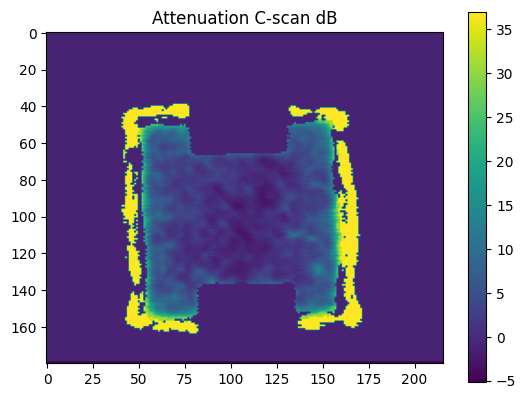

In [85]:
plt.imshow(attenuation_cscan)
#add a colorbar to the plot
plt.colorbar()
plt.title('Attenuation C-scan dB')
plt.show()

# Save the Cscan

In [86]:
#save the cscan as a tiff file with the same name as the original file but with _attenuation in the end
output_filename = filename.stem + '_attenuation.tif'
output_filename = Path(filename.parent, output_filename)
tifffile.imwrite(output_filename, attenuation_cscan.astype(np.float32))
print('Attenuation C-scan saved as:', output_filename)

Attenuation C-scan saved as: \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Fabricacion Nacho\medidas\Preliminar\Laminado_Preliminar_2\Sin cortar\Segunda_Placa_Nacho_20mms_30mm_11dB_121Z_ascan216x180x505_amplitude_attenuation.tif
